<a href="https://colab.research.google.com/github/KarenYu729/Pytorch-Note/blob/main/CV/MNIST_Handwritten_Digit_Recognition_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Handwritten Digit Recognition in PyTorch

1. get dataset

2. build training model

3. train

4. evaluate the model(test)

In [ ]:
import torch
import torchvision

# Get dataset

1. set some parameters

2. download MNIST dataset

[PyTorch > Datasets > MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html)

## set parameters

For repeatable experiments we have to set random seeds for anything using random number generation - this means numpy and random as well! It's also worth mentioning that cuDNN uses nondeterministic algorithms which can be disabled setting torch.backends.cudnn.enabled = False.

In [ ]:
n_epoch = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## torch.backends.cudnn.enabled = False

### TORCH.BACKENDS

torch.backends controls the behavior of various backends that PyTorch supports.

#### **torch.backends.cudnn.enabled**
A bool that controls whether cuDNN is enabled.




#### **When should we set torch.backends.cudnn.enabled to false**
[When should we set torch.backends.cudnn.enabled to false](https://discuss.pytorch.org/t/when-should-we-set-torch-backends-cudnn-enabled-to-false-especially-for-lstm/106571/6)

[set `torch.backends.cudnn.benchmark = True` or not?](https://stackoverflow.com/questions/58961768/set-torch-backends-cudnn-benchmark-true-or-not)

[Hi, why do you setup the torch.backends.cudnn.enabled False?](https://github.com/zzzxxxttt/pytorch_simple_CenterNet_45/issues/1)

[torch.backends.cudnn.enabled = False会引起CUDA out of memory和CUDA error: an illegal memory access was](https://blog.csdn.net/Strive_For_Future/article/details/120872249)

In [ ]:
cuDNN使用非确定性算法，并且可以使用torch.backends.cudnn.enabled = False来进行禁用

如果设置为torch.backends.cudnn.enabled =True，说明设置为使用使用非确定性算法

然后再设置：

torch.backends.cudnn.benchmark = true
那么cuDNN使用的非确定性算法就会自动寻找最适合当前配置的高效算法，来达到优化运行效率的问题

一般来讲，应该遵循以下准则：

如果网络的输入数据维度或类型上变化不大，设置  torch.backends.cudnn.benchmark = true  可以增加运行效率；
如果网络的输入数据在每次 iteration 都变化的话，会导致 cnDNN 每次都会去寻找一遍最优配置，这样反而会降低运行效率。
所以我们经常看见在代码开始出两者同时设置：

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
————————————————
版权声明：本文为CSDN博主「wzg2016」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/Strive_For_Future/article/details/120872249

## torch.manual_seed(random_seed)

Sets the seed for generating random numbers. Returns a torch.Generator object.

[TORCH.MANUAL_SEED](https://pytorch.org/docs/stable/generated/torch.manual_seed.html)

[What is manual_seed?](https://discuss.pytorch.org/t/what-is-manual-seed/5939)

## set dataloader & download dataset

Now we'll also need DataLoaders for the dataset. This is where TorchVision comes into play. It let's use load the MNIST dataset in a handy way. We'll use a batch_size of 64 for training and size 1000 for testing on this dataset. The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.

TorchVision offers a lot of handy transformations, such as cropping or normalization.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    trochvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,)
                                   )
                               ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,)
                                   )
                               ])),
    batch_size=batch_size_test, shuffle=True)


**准备数据集，其中0.1307，0.3081为MNIST数据的均值和标准差，这样操作能够对其进行标准化**

[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html)

CLASS</br>torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=None, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None, generator=None, *, prefetch_factor=2, persistent_workers=False, pin_memory_device='')



**DataLoader classes can use TorchVision Dataset objects to create automatic batches for training.** 

**torchvision.transforms.Compose**

Composes several transforms together.

```
transforms.Compose([
    transforms.CenterCrop(10),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
])
```

[TORCHVISION.TRANSFORMS](https://pytorch.org/vision/0.9/transforms.html)

Transforms are common image transformations. They can be chained together using Compose. Additionally, there is the torchvision.transforms.functional module. Functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline (e.g. in the case of segmentation tasks).

对图像进行一些变换，使用compose将多个compose方法结合在一起（类似pipeline），看意思还能换颜色空间

</br>

### **CLASS torchvision.transforms.ToTensor**
Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.

Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

In the other cases, tensors are returned without scaling.

将图像转换为张量


### **CLASS torchvision.transforms.Normalize(mean, std, inplace=False)**

Normalize a tensor image with mean and standard deviation. This transform does not support PIL Image. Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel]

对变换为tensor形式的image进行normalize，注意normalize的对象要是张量，所以在transform的时候要有一个顺序（即先转换为张量再进行其他操作）

# Some checking

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation = 'none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

fig

# Building the Networks

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    sef.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)
  
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2.drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

## class    _ _init_ _

**[Python __init__()类构造方法](http://c.biancheng.net/view/4533.html)**

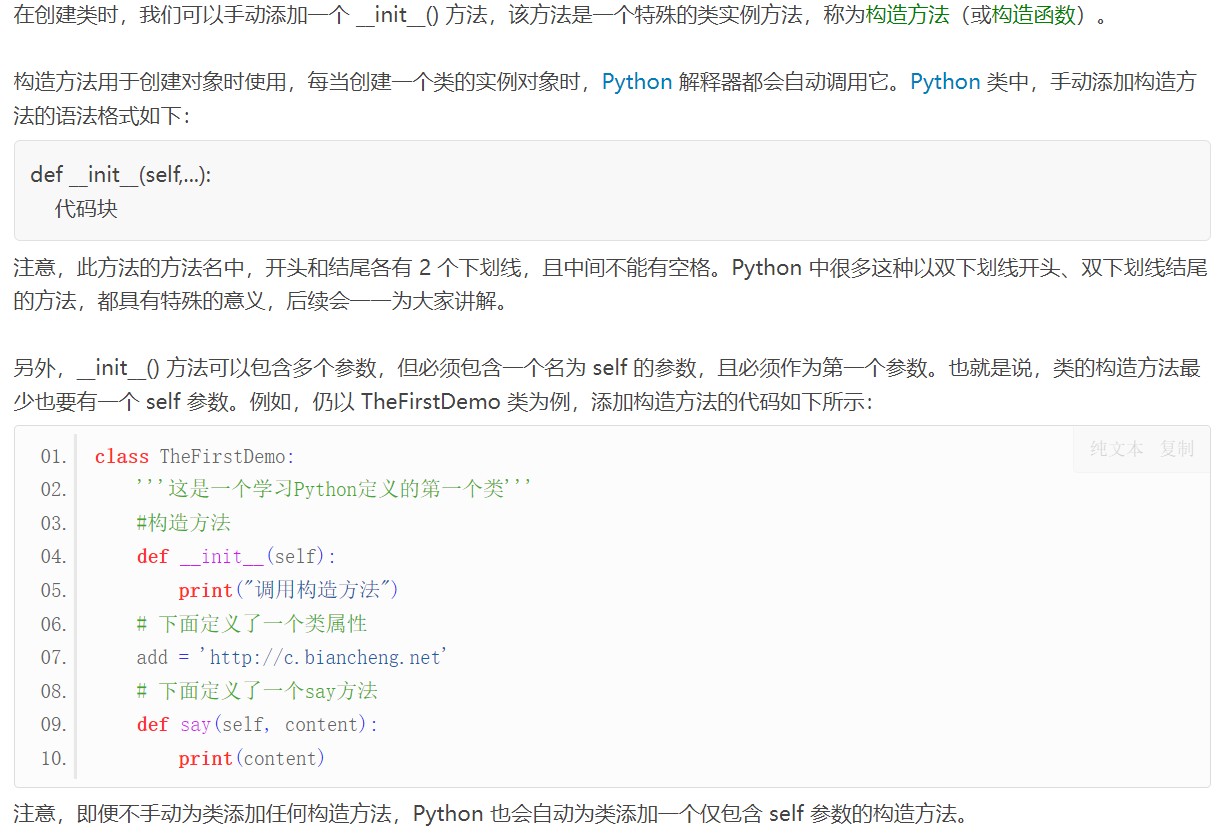

> Indented block



</br>

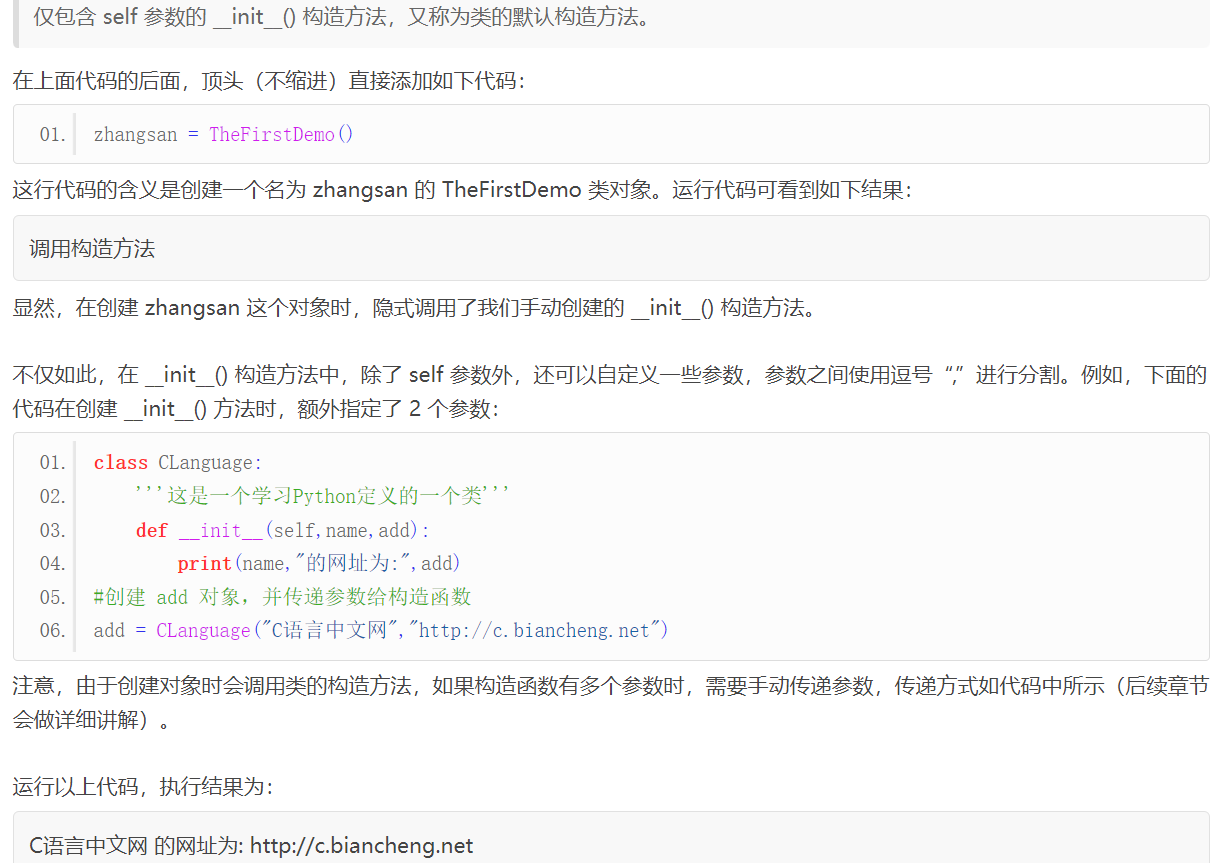

## **super(Net, self)._ _init_ _()**

[CSDN blog1 super(Net, self).__init__()](https://blog.csdn.net/qq_31244453/article/details/104657532)
</br></br>标准的解析如下，这是对继承自父类的属性进行初始化。而且是用父类的初始化方法来初始化继承的属性。也就是说，子类继承了父类的所有属性和方法，父类属性自然会用父类方法来进行初始化。

super(x,self).init()含义（单继承，即只有一个父类）在下面的代码中加入super(x,self).init()时调用son的父类farther的属性和方法（方法里对farther数据进行二次操作）



```
class farther(object):
    def __init__(self):
        self.x = '这是属性'
        
    def fun(self):
        print(self.x)
        print('这是方法')
        
class son(farther):
    def __init__(self):
        super(son,self).__init__()
        print('实例化执行')
            
test = son()
test.fun()
test.x



输出

实例化执行
这是属性
这是方法

如果没有super(x,self).__init__()，则输出为

AttributeError: 'son' object has no attribute 'x'

则son类不能继承父类的方法和参数。
```

[终于搞懂了Python中super(XXXX, self).__init__()的作用了](https://www.jb51.net/article/258207.htm)
</br></br>在使用pytorch框架时，难免要自己定义网络。于是，super(XXXX, self).init()，就成了自定义网络结构时必不可少的第一句。但是，super(XXXX, self).init()具体的作用是什么我一直没有搞清楚。阅读了大量的博客后，我终于搞懂了！

一言以蔽之：super(XXX, self).init()——对继承自父类的属性进行初始化，并且用父类的初始化方法初始化继承的属性。

我们先看一个简单的例子：



```
class Person():
    def __init__(self, name, gender):
        # 为name和gender赋值 
        self.name = name
        self.gender = gender
        
    def printinfo(self):
    
        print(self.name, self.gender)


# Stu类继承Person类        

class Stu(Person):
    def __init__(self, name, gender, school):
    
        # 使用父类的初始化方法来初始化子类name和gender属性
        super(Stu, self).__init__(name, gender)  
        
        self.school = school
        
    def printinfo(self):   
        # 对父类的printinfo方法进行重写
       
        print(self.name, self.gender, self.school) 


    
if __name__=='__main__':
    stu = Stu('Bob', 'female', '5th')
    stu.printinfo()

>>>
Bob female 5th
```


</br>
当然，如果初始化的逻辑与父类的不同，不使用父类的方法，自己重新初始化也是可以的。比如：



```
class Person(object):
    def __init__(self, name, gender, age):
        self.name = name
        self.gender = gender
        self.age = age
        
# Student类继承Person类
class Student(Person):
    def __init__(self, name, gender, age, school, score):
    
        # 调用父类的初始化方法，初始化name、gender、age属性
        super(Student, self).__init__(name,gender, age)
        
        # 对name、gender属性进行改写。age属性仍保持父类的初始化方法
        
        self.name = name.upper()  # 姓名改为大写
        self.gender = gender.upper()  # 性别改为大写
        self.school = school
        self.score = score
        
s = Student("Alice", "female", "18", "High school", "17")
print(s.name, s.gender, s.school, s.score)

>>>
ALICE FEMALE High school 17
```

</br>
在理解了上面的小例子后，我们再仔细研究一下机器学习中的代码：



```
class Net(nn.Module): # 继承自nn.Moudle

    def __init__(self):
    
        super(Net, self).__init__()
        # 输入图像channel：1；输出channel：6；5x5卷积核
        self.conv1 = nn.Conv2d(1, 6, 5)
```


super(Net, self).init()的含义：子类Net类继承父类nn.Module，super(Net, self).init()就是对继承自父类nn.Module的属性进行初始化。并且是用nn.Module的初始化方法来初始化继承的属性。

也就是：用父类的方法初始化子类的属性。

有的人肯定会问，为啥要用父类的方法去初始化属性呢？原因很简单：就是因为父类的方法已经写好了，我们只需要调用就可以了。难道你还想自己写一堆代码去初始化各种权重和参数，处理一堆forward和backward的逻辑吗？

最后，多一句嘴，介绍一写在python中__init()的作用

在python中创建类后，通常会创建一个 init__ ()方法，这个方法会在创建类的实例的时候自动执行。

## nn.Conv2d(1, 10, kernel_size=5)

[Docs > torch.nn > Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

## nn.Dropout2d()

[Docs > torch.nn > Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html)

**torch.nn.Dropout2d(p=0.5, inplace=False)**

Parameters:

*p (float, optional) – probability of an element to be zero-ed.*

*inplace (bool, optional) – If set to True, will do this operation in-place*

**Randomly zero out entire channels (a channel is a 2D feature map**

**Usually the input comes from nn.Conv2d modules.**

As described in the paper Efficient Object Localization Using Convolutional Networks , if adjacent pixels within feature maps are strongly correlated (as is normally the case in early convolution layers) then i.i.d. dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease.

In this case, nn.Dropout2d() will help promote independence between feature maps and should be used instead.

如果特征图中的相邻像素是强相关的(就像早期卷积层中的情况一样)，那么I.I.D. dropout将不会正则化激活，否则只会导致有效学习率的降低。</br>
在这种情况下，nn.Dropout2d()将有助于提高特性映射之间的独立性，应该使用它

我们知道如果要训练一个大型的网络，训练数据很少的话，那么很容易引起过拟合(也就是在测试集上的精度很低)，可能我们会想到用L2正则化、或者减小网络规模。然而深度学习领域大神Hinton，在2012年文献：《Improving neural networks by preventing co-adaptation of feature detectors》提出了，在每次训练的时候，让一半的特征检测器停过工作，这样可以提高网络的泛化能力，Hinton又把它称之为dropout。

Hinton认为过拟合，可以通过阻止某些特征的协同作用来缓解。在每次训练的时候，每个神经元有百分之50的几率被移除，这样可以让一个神经元的出现不应该依赖于另外一个神经元。

另外，我们可以把dropout理解为 模型平均。 假设我们要实现一个图片分类任务，我们设计出了100000个网络，这100000个网络，我们可以设计得各不相同，然后我们对这100000个网络进行训练，训练完后我们采用平均的方法，进行预测，这样肯定可以提高网络的泛化能力，或者说可以防止过拟合，因为这100000个网络，它们各不相同，可以提高网络的稳定性。而所谓的dropout我们可以这么理解，这n个网络，它们权值共享，并且具有相同的网络层数(这样可以大大减小计算量)。我们每次dropout后，网络模型都可以看成是整个网络的子网络。(需要注意的是如果采用dropout，训练时间大大延长，但是对测试阶段没影响)。

啰嗦了这么多，那么到底是怎么实现的？Dropout说的简单一点就是我们让在前向传导的时候，让某个神经元的激活值以一定的概率p，让其停止工作，示意图如下：

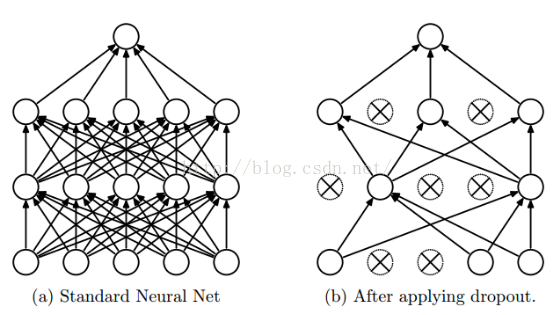 

左边是原来的神经网络，右边是采用Dropout后的网络。这个说是这么说，但是具体代码层面是怎么实现的？怎么让某个神经元以一定的概率停止工作？这个我想很多人还不是很了解，代码层面的实现方法，下面就讲解一下其代码层面的实现。以前我们网络的计算公式是：

 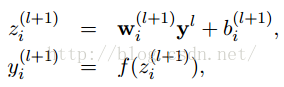

采用dropout后计算公式就变成了：

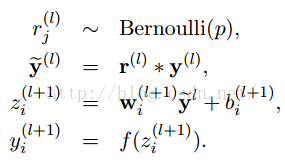 

上面公式中Bernoulli函数，是为了以概率p，随机生成一个0、1的向量。
————————————————
版权声明：本文为CSDN博主「hjimce」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/hjimce/article/details/50413257

## x = F.relu(F.max_pool2d(self.conv1(x), 2))

[Docs > torch.nn.functional > torch.nn.functional.max_pool2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html)

[【PyTorch】nn.MaxPool2d函数详解](https://blog.csdn.net/See_Star/article/details/127565842)

## self.fc1 = nn.Linear(320, 50)

为什么是320

最开始一张图片是28×28×1（一个channel）



```
x = F.relu(F.max_pool2d(self.conv1(x), 2))
```

首先self.conv1(x)，第一层卷积

```
nn.Conv2d(1, 10, kernel_size=5)
```
从一个通道（channel）变为10个，且有一个5×5的卷积核，也就是每个通道的大小都缩小为28-5+1（24×24），十个通道就是24×24×10

然后是一层池化，池化所用的核的大小是2（相当于直接缩小到½），即用2×2的数据中的最大值代替这个2×2矩阵，则此时十个通道变为12×12×10


```
x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
```
类似的，内层的卷积层从10个通道到20个通道，卷积核还是5，所以最后得到的是8×8×20，池化完之后是4×4×20

**全连接层平铺显然就是**

——》320




## x = x.view(-1, 320)

[Docs > torch.Tensor > torch.Tensor.view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)

Returns a new tensor with the same data as the self tensor but of a different shape.

**the size -1 is inferred from other dimensions**

```
>>> x = torch.randn(4, 4)
>>> x.size()
torch.Size([4, 4])
>>> y = x.view(16)
>>> y.size()
torch.Size([16])
>>> z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
>>> z.size()
torch.Size([2, 8])
```



## x = F.dropout(x, training=self.training)
[Docs > torch.nn.functional > torch.nn.functional.dropout](https://pytorch.org/docs/stable/generated/torch.nn.functional.dropout.html)

During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution.

## return F.log_softmax(x)
[Docs > torch.nn.functional > torch.nn.functional.log_softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html)

Applies a softmax followed by a logarithm.

While mathematically equivalent to log(softmax(x)), doing these two operations separately is slower and numerically unstable. This function uses an alternative formulation to compute the output and gradient correctly.

Broadly speaking we can think of the torch.nn layers as which contain trainable parameters while torch.nn.functional are purely functional. The forward() pass defines the way we compute our output using the given layers and functions. It would be perfectly fine to print out tensors somewhere in the forward pass for easier debugging. This comes in handy when experimenting with more complex models. Note that the forward pass could make use of e.g. a member variable or even the data itself to determine the execution path - and it can also make use of multiple arguments!

### Now let's initialize the network and the optimizer.

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

[Pytorch nn.Module模块详解](https://blog.csdn.net/weixin_42018112/article/details/90084419)

**如何定义自己的网络：**

1. 需要继承nn.Module类，并实现forward方法。继承nn.Module类之后，在构造函数中要调用Module的构造函数, super(Linear, self).init()

2. 一般把网络中具有可学习参数的层放在构造函数_ _init_ _()中。

3. 不具有可学习参数的层（如ReLU）可放在构造函数中，也可不放在构造函数中（而在forward中使用nn.functional来代替）。可学习参数放在构造函数中，并且通过nn.Parameter()使参数以parameters（一种tensor,默认是自动求导）的形式存在Module中，并且通过parameters()或者named_parameters()以迭代器的方式返回可学习参数。

4. 只要在nn.Module中定义了forward函数，backward函数就会被自动实现（利用Autograd)。而且一般不是显式的调用forward(layer.forward), 而是layer(input), 会自执行forward().

5. 在forward中可以使用任何Variable支持的函数，毕竟在整个pytorch构建的图中，是Varible在流动。还可以使用if, for, print, log等python语法。

</br></br>
torch.nn.Module()函数 torch.nn.Module是所有神经网络模块的基类,所有的神经网络模型都应该继承这个基类,即PyTorch都应该是nn.mudule的子类

### optim.SGD

SGD为随机梯度下降法

在每次更新时用1个样本，可以看到多了随机两个字，随机也就是说我们用样本中的一个例子来近似我所有的样本，来调整θ，因而随机梯度下降是会带来一定的问题，因为计算得到的并不是准确的一个梯度，对于最优化问题，凸问题，虽然不是每次迭代得到的损失函数都向着全局最优方向， 但是大的整体的方向是向全局最优解的，最终的结果往往是在全局最优解附近。但是相比于批量梯度，这样的方法更快，更快收敛，虽然不是全局最优，但很多时候是我们可以接受的

[神经网络(深度学习)常用的4种最优化方法——SGD、Momentum、AdaGrad、Adam](https://blog.csdn.net/qq_43721542/article/details/99642750?spm=1001.2101.3001.6650.1&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-1-99642750-blog-123198293.pc_relevant_recovery_v2&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-1-99642750-blog-123198293.pc_relevant_recovery_v2&utm_relevant_index=2)

[深度学习入门之SGD随机梯度下降法](https://blog.csdn.net/weixin_46713695/article/details/123198293)

[SGD（随机梯度下降）详解](https://blog.csdn.net/weixin_46301248/article/details/105883723)


BGD、SGD在工程选择上的tricks

BGD：相对噪声低些，幅度也大一些，你可以继续找最小值。

SGD：大部分时候你向着全局最小值靠近，有时候你会远离最小值，因为那个样本恰好给你指的方向不对，因此SGD是有很多噪声的，平均来看，它最终会靠近最小值，不过有时候也会方向错误，因为SGD永远不会收敛，而是会一直在最小值附近波动。一次性只处理了一个训练样本，这样效率过于低下。

mini-batch：实践中最好选择不大不小的 mini-batch，得到了大量向量化，效率高，收敛快。
调节 Batch_Size 对训练效果影响到底如何？

Batch_Size 太小，模型表现效果极其糟糕(error飙升)。

随着 Batch_Size 增大，处理相同数据量的速度越快。

随着 Batch_Size 增大，达到相同精度所需要的 epoch 数量越来越多。

由于上述两种因素的矛盾， Batch_Size 增大到某个时候，达到时间上的最优。

由于最终收敛精度会陷入不同的局部极值，因此 Batch_Size 增大到某些时候，达到最终收敛精度上的最优。

如果训练集较小(小于 2000 个样本)，直接使用BGD法，一般的 mini-batch 大小为 64 到 512，考虑到电脑内存设置和使用的方式，如果 mini-batch 大小是 2^{n} ，代码会运行地快一些。

</br></br>

[Docs > torch.optim > SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False, *, maximize=False, foreach=None, differentiable=False)


Parameters:

**params (iterable)** – iterable of parameters to optimize or dicts defining parameter groups

**lr (float)** – learning rate

**momentum (float, optional)** – momentum factor (default: 0)

**weight_decay (float, optional)** – weight decay (L2 penalty) (default: 0)

**dampening (float, optional)** – dampening for momentum (default: 0)

**nesterov (bool, optional)** – enables Nesterov momentum (default: False)

**maximize (bool, optional)** – maximize the params based on the objective, instead of minimizing (default: False)

**foreach (bool, optional)** – whether foreach implementation of optimizer is used (default: None)

#### **momentum 动量**
“动量”这个概念源自于物理学，解释力在一段时间内作用所产生的物理量。我们没必要往复杂想，其实我们可以将动量约等于惯性。我们对惯性的基本理解就是: 当你跑起来，由于惯性的存在你跑起来会比刚起步加速的时候更轻松，当你跑过头，想调头往回跑，惯性会让你拖着你。
在普通的梯度下降法的方向相同，则会加速。反之，则会减速。加动量的优势有两点：
1. 加速收敛
2. 提高精度(减少收敛过程中的振荡)


# Training the Model

First we need to manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients. We then produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label. The backward() call we now collect a new set of gradients which we propagate back into each of the network's parameters using optimizer.step(). For more detailed information about the inner workings of PyTorch's automatic gradient system, see the official docs for autograd (highly recommended).

首先，我们需要使用optimizer.zero_grad()手动将渐变设置为0，因为PyTorch默认情况下会累积渐变。然后，我们生成网络的输出(向前传递)，并计算输出和地面真相标签之间的负对数似然损失。backward()调用现在收集了一组新的梯度，使用optimizer.step()将其传播回每个网络参数中。有关PyTorch自动渐变系统内部工作原理的更多详细信息，请参阅autograd的官方文档(强烈推荐)。

## create two lists for saving training and testing losses



In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

## train

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()
      ))
      train_losses.append(loss.item())
      train_counter.append(
          (batch_idx*64) * ((epoch-1)*len(train_loader.dataset))
      )
      torch.save(network.state_dict(), '/results/nodel.pth')
      torch.save(optimizer.state_dict(), '/results/optimizer.pth')


### for batch_idx, (data, target) in enumerate(train_loader):

通常，在处理迭代器时，我们还需要保持迭代的计数。Python为这个任务提供了内置函数enumerate()，从而简化了程序员的任务。Enumerate()方法将一个计数器添加到可迭代对象中，并以枚举对象的形式返回。然后可以直接将该枚举对象用于循环，或使用list()方法将其转换为元组列表。

**Syntax:**

enumerate(iterable, start=0)

**Parameters:**

*Iterable*: any object that supports iteration

*Start*: the index value from which the counter is to be started, by default it is 0

</br></br>
enumerate多用于在for循环中得到计数，利用它可以同时获得索引和值，即需要index和value值的时候可以使用enumerate
enumerate()返回的是一个enumerate对象

```
s = [1, 2, 3, 4, 5]
e = enumerate(s)
for index, value in e:
    print('%s, %s' % (index, value))
 
输出结果：
0, 1
1, 2
2, 3
3, 4
4, 5
___________________________________
 s = [1, 2, 3, 4, 5]
# 从指定索引1开始
for index, value in enumerate(s, 1):
    print('%s, %s' % (index, value))
 
输出结果：
1, 1
2, 2
3, 3
4, 4
5, 5
___________________________________
 s = [1, 2, 3, 4, 5]
# 从指定索引3开始
for index, value in enumerate(s, 3):
    print('%s, %s' % (index, value))
 
输出结果：
3, 1
4, 2
5, 3
6, 4
7, 5
```



### optimizer.zero_grad()

[Why do we need to call zero_grad() in PyTorch?](https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)

传统的训练函数，一个batch是这么训练的：


```
for i,(images,target) in enumerate(train_loader):
    # 1. input output
    images = images.cuda(non_blocking=True)
    target = torch.from_numpy(np.array(target)).float().cuda(non_blocking=True)
    outputs = model(images)
    loss = criterion(outputs,target)
 
    # 2. backward
    optimizer.zero_grad()   # reset gradient
    loss.backward()
    optimizer.step()    
```
        
获取loss：输入图像和标签，通过infer计算得到预测值，计算损失函数；

optimizer.zero_grad() 清空过往梯度；

loss.backward() 反向传播，计算当前梯度；

optimizer.step() 根据梯度更新网络参数

简单的说就是进来一个batch的数据，计算一次梯度，更新一次网络


**以SGD为例，是算一个batch计算一次梯度，然后进行一次梯度更新。这里梯度值就是对应偏导数的计算结果。显然，我们进行下一次batch梯度计算的时候，前一个batch的梯度计算结果，没有保留的必要了。所以在下一次梯度更新的时候，先使用optimizer.zero_grad把梯度信息设置为0。**

In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero before starting to do backpropragation (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes. This accumulating behaviour is convenient while training RNNs or when we want to compute the gradient of the loss summed over multiple mini-batches. So, the default action has been set to accumulate (i.e. sum) the gradients on every loss.backward() call.

Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. Otherwise, the gradient would be a combination of the old gradient, which you have already used to update your model parameters, and the newly-computed gradient. It would therefore point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).

### loss = F.nll_loss(output, target)

[Docs > torch.nn.functional > torch.nn.functional.nll_loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.nll_loss.html)

[【pytorch笔记】损失函数nll_loss](https://blog.csdn.net/GentleCP/article/details/106602179)
在用pytorch做训练、测试时经常要用到损失函数计算输出与目标结果的差距，例如下面的代码：


```
# 训练
for batch_idx, (data, target) in enumerate(train_loader):
	data, target = data.to(device), target.to(device)
	optimizer.zero_grad()
	output = model(data)
	loss = F.nll_loss(output, target)
	loss.backward()
	optimizer.step()
# 测试
for data, target in test_loader:
	data, target = data.to(device), target.to(device)
	output = model(data)
	test_loss += F.nll_loss(output, target, reduction = 'sum')
```


前一部分是训练过程，计算输出output与target的误差回传，后一部分是测试过程，计算output与target误差，并进行误差求和。

函数理解
官方函数定义
在该函数中重要的参数主要有三个，分别是：

*input:(N,C),其中C表示分类的数量，N表示数据的条数，由于数据的输入是按batch输入，所以N也是batch的大小。*

*target:(N)目标结果，即常见分类任务中的label，包含N个。*

*reduction：对计算结果采取的操作，通常我们用sum（对N个误差结果求和）,mean（对N个误差结果取平均），默认是对所有样本求loss均值*


在很多论文中，我们看到loss有时候用的NLLLoss，有时候用的CrossEntropyLoss，这个主要的区别是什么？

如下：

`cross_entropy_mean = F.nll_loss(log_preds, labels)`
或者

`loss = nn.NLLLoss()`

很多人很难理解，不是求的交叉熵损损失吗？怎么返回的是nll_loss呢?

**其实，NLLloss+log+softmax就是CrossEntropyLoss，而其中的NLLloss就是在做交叉熵损失函数的最后一步：预测结果的删除负号，然后求和。**

前面return的部分是log(softmax())

[神经网络中NLLLoss和CrossEntropyLoss的快速理解](https://zhuanlan.zhihu.com/p/589631793)

### loss.backward()

[理解Pytorch的loss.backward()和optimizer.step()](https://zhuanlan.zhihu.com/p/445009191)

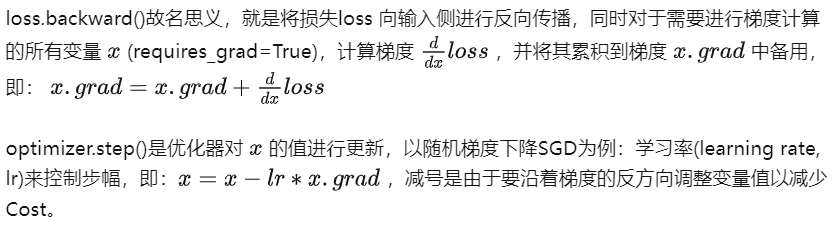



```
x = torch.tensor([1., 2.], requires_grad=True)
# x: tensor([1., 2.], requires_grad=True) 
y = 100*x
# y: tensor([100., 200.], grad_fn=<MulBackward0>)

loss = y.sum(). # tensor(300., grad_fn=<SumBackward0>)

# Compute gradients of the parameters respect to the loss
print(x.grad)     # None, 反向传播前，梯度不存在
loss.backward()      
print(x.grad)     # tensor([100., 100.]) loss对y的梯度为1， 对x的梯度为100

optim = torch.optim.SGD([x], lr=0.001) # 随机梯度下降， 学习率0.001
print(x)        # tensor([1., 2.], requires_grad=True)
optim.step()  # 更新x
print(x)        # tensor([0.9000, 1.9000], requires_grad=True) 变化量=梯度X学习率 0.1=100*0.001
```

[Docs » Deep Learning with PyTorch: A 60 Minute Blitz » Neural Networks](http://seba1511.net/tutorials/beginner/blitz/neural_networks_tutorial.html)

### optimizer.step()

[“反向传播算法”过程及公式推导（超直观好懂的Backpropagation）](https://blog.csdn.net/ft_sunshine/article/details/90221691)


```
optimizer.zero_grad()：先将梯度归零
loss.backward()：反向传播计算得到每个参数的梯度值
optimizer.step()：通过梯度下降执行一步参数更新
```
[pytorch--＞optimizer.zero_grad()、loss.backward()、optimizer.step()和scheduler.step()](https://blog.csdn.net/weixin_45072810/article/details/109687210?spm=1001.2101.3001.6650.3&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-109687210-blog-99963586.pc_relevant_3mothn_strategy_recovery&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-109687210-blog-99963586.pc_relevant_3mothn_strategy_recovery&utm_relevant_index=6)


## test

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss:{:.4f}, Accuracy: {}/{} ({:.of}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)
  ))

### network.eval()

[torch.nn.Module.train() & torch.nn.Module.eval()](https://www.cnblogs.com/wupiao/articles/13287061.html)

train:将模块设置为训练模式。
eval:将模块设为评估模式。

### pred = output.data.max(1, keepdim=True)[1]

获取最大值的位置,[batch_size,1]

`get the index of the max log-probability，最后一层输出10个数，值最大的那个即对应着分类结果，然后把分类结果保存在 pred 里`

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

# Evaluating the Model's Performance

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [ ]:
with torch.no_grad():
  output = network(example_data)

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

# Continued Training from Checkpoints

In [ ]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [ ]:
network_state_dict = torch.load('/results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# code 1

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

In [6]:
# 一个函数，用来计算模型中有多少参数
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np
 
# 使用GPU训练
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
input_size  = 28*28   # MNIST上的图像尺寸是 28x28
output_size = 10      # 类别为 0 到 9 的数字，因此为十类
 
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=64, shuffle=True)
 
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=1000, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



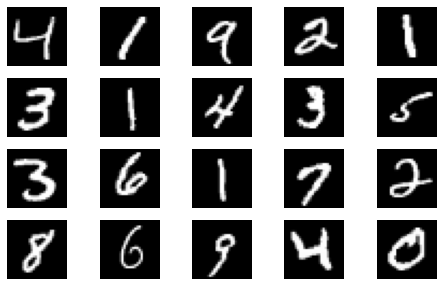

In [8]:
plt.figure(figsize=(8, 5))
for i in range(2,22):
    plt.subplot(4, 5, i-1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(),'gray')
    plt.axis('off');

In [9]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        # 下式等价于nn.Module.__init__(self)        
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        # 这里直接用 Sequential 就定义了网络，注意要和下面 CNN 的代码区分开
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        # view一般出现在model类的forward函数中，用于改变输入或输出的形状
        # x.view(-1, self.input_size) 的意思是多维的数据展成二维
        # 代码指定二维数据的列数为 input_size=784，行数 -1 表示我们不想算，电脑会自己计算对应的数字
        # 在 DataLoader 部分，我们可以看到 batch_size 是64，所以得到 x 的行数是64
        # 大家可以加一行代码：print(x.cpu().numpy().shape)
        # 训练过程中，就会看到 (64, 784) 的输出，和我们的预期是一致的
 
        # forward 函数的作用是，指定网络的运行过程，这个全连接网络可能看不啥意义，
        # 下面的CNN网络可以看出 forward 的作用。
        x = x.view(-1, self.input_size)
        return self.network(x)

In [10]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        # 执行父类的构造函数，所有的网络都要这么写
        super(CNN, self).__init__()
        # 下面是网络里典型结构的一些定义，一般就是卷积和全连接
        # 池化、ReLU一类的不用在这里定义
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)    
    
    # 下面的 forward 函数，定义了网络的结构，按照一定顺序，把上面构建的一些结构组织起来
    # 意思就是，conv1, conv2 等等的，可以多次重用
    def forward(self, x, verbose=False):
        x = self.conv1(x)#卷积
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)#最大值池化，卷积核为2*2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [11]:
def train(model):
    model.train()
    # 主里从train_loader里，64个样本一个batch为单位提取样本进行训练
    for batch_idx, (data, target) in enumerate(train_loader):
        # 把数据送到GPU中
        data, target = data.to(device), target.to(device)
 
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [12]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # 把数据送到GPU中
        data, target = data.to(device), target.to(device)
        # 把数据送入模型，得到预测结果
        output = model(data)
        # 计算本次batch的损失，并加到 test_loss 中
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        # get the index of the max log-probability，最后一层输出10个数，
        # 值最大的那个即对应着分类结果，然后把分类结果保存在 pred 里
        pred = output.data.max(1, keepdim=True)[1]
        # 将 pred 与 target 相比，得到正确预测结果的数量，并加到 correct 中
        # 这里需要注意一下 view_as ，意思是把 target 变成维度和 pred 一样的意思                                                
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
 
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [13]:
n_hidden = 8 # number of hidden units
 
model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))
 
train(model_fnn)
test(model_fnn)

Number of parameters: 6442
Train: [0/60000 (0%)]	Loss: 2.337832
Train: [6400/60000 (11%)]	Loss: 1.971586
Train: [12800/60000 (21%)]	Loss: 1.259004
Train: [19200/60000 (32%)]	Loss: 1.047343
Train: [25600/60000 (43%)]	Loss: 0.754502
Train: [32000/60000 (53%)]	Loss: 0.584761
Train: [38400/60000 (64%)]	Loss: 0.503391
Train: [44800/60000 (75%)]	Loss: 0.359832
Train: [51200/60000 (85%)]	Loss: 0.364623
Train: [57600/60000 (96%)]	Loss: 0.379687

Test set: Average loss: 0.3990, Accuracy: 8807/10000 (88%)



In [14]:
# Training settings 
n_features = 6 # number of feature maps
 
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))
 
train(model_cnn)
test(model_cnn)

Number of parameters: 6422
Train: [0/60000 (0%)]	Loss: 2.301506
Train: [6400/60000 (11%)]	Loss: 2.025658
Train: [12800/60000 (21%)]	Loss: 0.557461
Train: [19200/60000 (32%)]	Loss: 0.381192
Train: [25600/60000 (43%)]	Loss: 0.315854
Train: [32000/60000 (53%)]	Loss: 0.359600
Train: [38400/60000 (64%)]	Loss: 0.147848
Train: [44800/60000 (75%)]	Loss: 0.161827
Train: [51200/60000 (85%)]	Loss: 0.116119
Train: [57600/60000 (96%)]	Loss: 0.093520

Test set: Average loss: 0.1871, Accuracy: 9415/10000 (94%)



In [15]:
# 对每个 batch 里的数据，打乱像素顺序的函数
def perm_pixel(data, perm):
    # 转化为二维矩阵
    data_new = data.view(-1, 28*28)
    # 打乱像素顺序
    data_new = data_new[:, perm]
    # 恢复为原来4维的 tensor
    data_new = data_new.view(-1, 1, 28, 28)
    return data_new
 
# 训练函数
def train_perm(model, perm):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # 像素打乱顺序
        data = perm_pixel(data, perm)
 
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
 
# 测试函数
def test_perm(model, perm):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
 
        # 像素打乱顺序
        data = perm_pixel(data, perm)
 
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]                                            
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
 
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [16]:
perm = torch.randperm(784)
n_hidden = 8 # number of hidden units
 
model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))
 
train_perm(model_fnn, perm)
test_perm(model_fnn, perm)

Number of parameters: 6442
Train: [0/60000 (0%)]	Loss: 2.305179
Train: [6400/60000 (11%)]	Loss: 1.936270
Train: [12800/60000 (21%)]	Loss: 1.654714
Train: [19200/60000 (32%)]	Loss: 1.276866
Train: [25600/60000 (43%)]	Loss: 1.015481
Train: [32000/60000 (53%)]	Loss: 0.928504
Train: [38400/60000 (64%)]	Loss: 0.779411
Train: [44800/60000 (75%)]	Loss: 0.713768
Train: [51200/60000 (85%)]	Loss: 0.526105
Train: [57600/60000 (96%)]	Loss: 0.503323

Test set: Average loss: 0.4954, Accuracy: 8531/10000 (85%)



In [17]:
perm = torch.randperm(784)
n_features = 6 # number of feature maps
 
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))
 
train_perm(model_cnn, perm)
test_perm(model_cnn, perm)

Number of parameters: 6422
Train: [0/60000 (0%)]	Loss: 2.318061
Train: [6400/60000 (11%)]	Loss: 2.242505
Train: [12800/60000 (21%)]	Loss: 2.185059
Train: [19200/60000 (32%)]	Loss: 1.796565
Train: [25600/60000 (43%)]	Loss: 1.369921
Train: [32000/60000 (53%)]	Loss: 0.840219
Train: [38400/60000 (64%)]	Loss: 0.860449
Train: [44800/60000 (75%)]	Loss: 0.479005
Train: [51200/60000 (85%)]	Loss: 0.566193
Train: [57600/60000 (96%)]	Loss: 0.530679

Test set: Average loss: 0.5010, Accuracy: 8463/10000 (85%)



# code 2

In [18]:
import torch
import torchvision

In [19]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [20]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [21]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [22]:
example_data.shape

torch.Size([1000, 1, 28, 28])

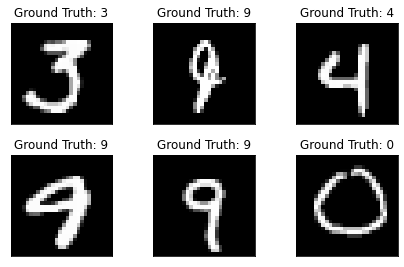

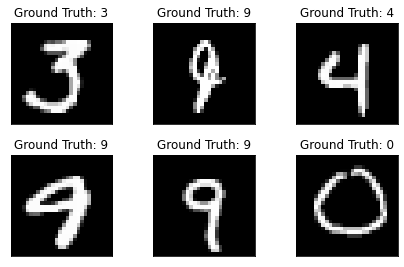

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [26]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [27]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [31]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [32]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [33]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-25-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3084, Accuracy: 923/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324247
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.273413
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.252027
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.279411
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.259859
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.255871
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.175713
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.212805
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.093185
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.029723
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.901314
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.907668
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.777701
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.564114
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.369018
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.345432
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.406255
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.167964
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.430185
Train Epoch: 1 [12160/6

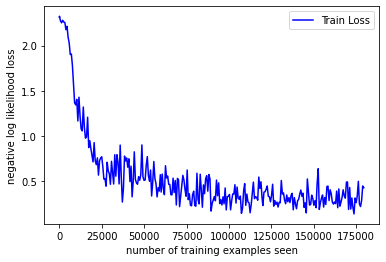

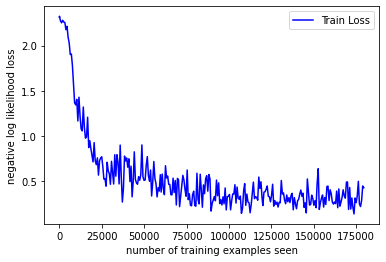

In [35]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [36]:
with torch.no_grad():
  output = network(example_data)

<ipython-input-25-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


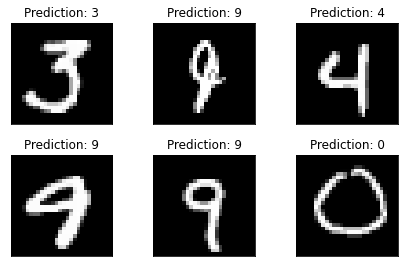

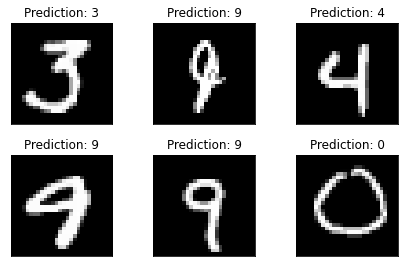

In [37]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [38]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [39]:
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [40]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

<ipython-input-25-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.230142
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.357678
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.136790
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.345480
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.213770
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.227505
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.373629
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.256830
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.314568
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.270578
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.313672
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.225068
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.257387
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.375731
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.321556
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.260682
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.184233
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.204237
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.291286
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.264932
Train Epoch: 4 [12800/60000 (

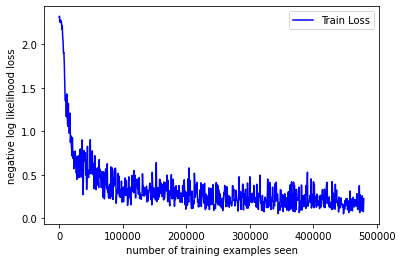

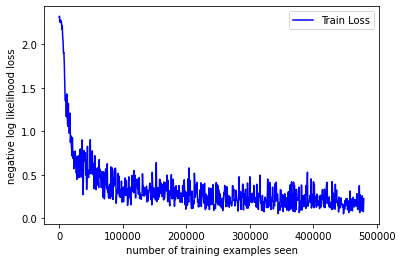

In [42]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig